![alt text](https://sijai.com/wp-content/uploads/2017/07/bismillahirrahmanirrahim-khasiatobatdaunsirsakblog-wordpress-com-1.jpg)

Referensi Paper : 


1. https://arxiv.org/pdf/1809.04115.pdf



Hint Parameter : 
1.   https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
2.   http://cs231n.github.io/neural-networks-3/#gradcheck

Hint Test Model : 

1.   https://github.com/zdmc23/oneshot-audio/blob/master/OneShot.ipynb





In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2,l1
from keras import backend as K
from keras.optimizers import SGD,Adam,RMSprop
from keras import initializers
import numpy as np
import random

Using TensorFlow backend.


In [0]:
num_classes = 3
epoch = 20


In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [0]:
def build_net_encoder(input_shape):
  
  input=Input(shape=input_shape)
  x=Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1),padding='same',kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',data_format='channels_last',input_shape=input_shape,
           activation='relu',name='layer_1')(input)
  x=Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1),kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',padding='same',activation='relu',name='layer_2')(x)
  x=MaxPooling2D(strides=(2,2),padding='same')(x)
  x=Conv2D(filters=128,kernel_size=(3,3),kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',strides=(1, 1),padding='same',activation='relu',name='layer_3')(x)
  x=Conv2D(filters=128,kernel_size=(3,3),kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',strides=(1, 1),padding='same',activation='relu',name='layer_4')(x)
  x=MaxPooling2D(strides=(2,2),padding='same')(x)
  x=Flatten(name='Layer_Klasifikasi')(x)
  x=Dense(1024,kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',activation='relu',name='layer_5')(x)
  x=Dense(1024,kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',activation='relu',name='layer_6')(x)
  x=Dense(num_classes,activation='softmax',kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',name='layer_7_output')(x)
   
  return Model(input,x)

def load_data(filepathX,filepathY):
  X=np.load(filepathX)
  Y=np.load(filepathY)
  
  return X,Y

In [0]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
#     random.seed()
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    print(n)
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
#             randomNum.append(inc)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

FUNGSI MAIN 

In [0]:
#ini MFCC
X_train,Y_train=load_data('/content/drive/My Drive/dataset/Train/TrainSetMFCC.npy','/content/drive/My Drive/dataset/Train/TrainlabelMFCC.npy')
X_val,Y_val=load_data('/content/drive/My Drive/dataset/Validation/ValSetMFCC.npy','/content/drive/My Drive/dataset/Validation/VallabelMFCC.npy')
X_test,Y_test=load_data('/content/drive/My Drive/dataset/TestSet/TestSetMFCC.npy','/content/drive/My Drive/dataset/TestSet/TestlabelMFCC.npy')

X_train=X_train.reshape(-1,X_train.shape[1],X_train.shape[2],1)
X_val=X_val.reshape(-1,X_val.shape[1],X_val.shape[2],1)
X_test=X_test.reshape(-1,X_test.shape[1],X_test.shape[2],1)


(1665, 100, 32, 1)


In [0]:
#create pair set

#Train
speaker_indices = [np.where(Y_train == i)[0] for i in range(num_classes)]
Train_pair,Train_label=create_pairs(X_train, speaker_indices)


#Validation
speakerval_indices = [np.where(Y_val == i)[0] for i in range(num_classes)]
Val_pair,Val_label=create_pairs(X_val, speakerval_indices)

input_shape=X_val.shape[1:]
print(input_shape)

[0 0 0 ... 0 0 0]
-1
[] []


In [0]:
encoder=build_net_encoder(input_shape)

left_in=Input(shape=input_shape,name='left_input')
right_in=Input(shape=input_shape,name='right_input')

left_net=encoder(left_in)
right_net=encoder(right_in)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([left_net, right_net])

siamese= Model([left_in, right_in], distance)
siamese.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         (None, 97, 32, 1)    0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        (None, 97, 32, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 3)            27462243    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None

In [0]:
#get initial weight and bias
weight=[]
for lay in encoder.layers:
    print(lay.name)
    print(lay.get_weights())
    weight.append(lay.get_weights())

In [0]:
# train

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=4, verbose=1)

optimizer = SGD(lr=0.01, decay=0.1, momentum=0.1, nesterov=False)
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])
history=siamese.fit([Train_pair[:, 0], Train_pair[:, 1]], Train_label,
          batch_size=50,
          epochs=epoch,
          shuffle=False,
          callbacks=[early_stopping],
          validation_data=([Val_pair[:, 0], Val_pair[:, 1]], Val_label))

#solusi nya bikin si model nge inisialisasi ulang weight dan bias nya saja

Instructions for updating:
Use tf.cast instead.
Train on 9984 samples, validate on 6654 samples
Epoch 1/20
9984/9984 [==============================] - 30s 3ms/step - loss: 0.1634 - accuracy: 0.7552 - val_loss: 0.1455 - val_accuracy: 0.7839
Epoch 2/20
9984/9984 [==============================] - 24s 2ms/step - loss: 0.1146 - accuracy: 0.8267 - val_loss: 0.1339 - val_accuracy: 0.8127
Epoch 3/20
9984/9984 [==============================] - 24s 2ms/step - loss: 0.1078 - accuracy: 0.8319 - val_loss: 0.1304 - val_accuracy: 0.8209
Epoch 4/20
9984/9984 [==============================] - 24s 2ms/step - loss: 0.1043 - accuracy: 0.8375 - val_loss: 0.1282 - val_accuracy: 0.8263
Epoch 5/20
9984/9984 [==============================] - 24s 2ms/step - loss: 0.1022 - accuracy: 0.8407 - val_loss: 0.1266 - val_accuracy: 0.8302
Epoch 6/20
9984/9984 [==============================] - 24s 2ms/step - loss: 0.1007 - accuracy: 0.8431 - val_loss: 0.1253 - val_accuracy: 0.8323
Epoch 7/20
9984/9984 [============

RESULT 

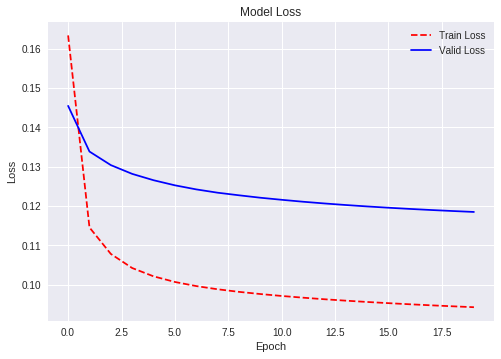

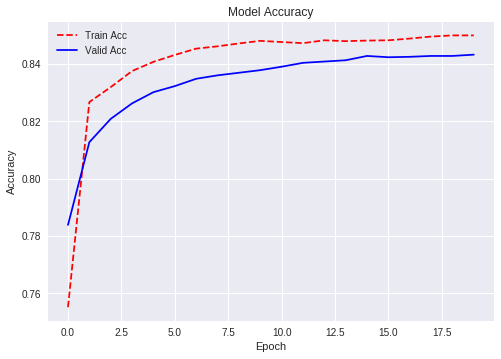

In [0]:

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['accuracy'],'r--')
    plt.plot(history.history['val_accuracy'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [0]:
from numpy.random import randint

def klasisifkasi(model_siamese,data_sampel,train_sampel):
  pass


def beta_classification(model_siamese,data_sampel,train_sampel,train_batas_atas,train_batas_bawah):
  indeks=np.random.randint(low=train_batas_bawah,high=train_batas_atas)
  model_siamese.predict([np.expand_dims(train_sampel[indeks,:],axis=0),np.expand_dims(data_sampel,axis=0)])

In [0]:
#test model
#solusi ribet : 
#ambil satu sampel acak per kelas untuk dibandingkan

TEST_VAR=3552
TRAIN_VAR=3000
# print(Y_test[0:1332]) # kelas 2
# print(Y_test[1332:2664]) #kelas 1
# print(Y_test[2664:5328]) #kelas 0

# print(Y_train[0:1665]) #kelas 1
# print(Y_train[1665:3330]) #kelas 0
# print(Y_train[3330:6660]) #kelas 2

kelas1_test=X_test[2664:5328]
kelas2_test=X_test[1332:2664]
kelas3_test=X_test[0:1332]

kelas1_train=X_test[1665:3330]
kelas2_train=X_test[0:1665]
kelas3_train=X_test[3330:6660]

# beta_classification(siamese,kelas1_test[1],kelas1_train,3330,1665)

print(Y_train[TRAIN_VAR])
print(Y_test[TEST_VAR])

#parameter (datasampel yang dimiliki,datasampel input suara)
siamese.predict([np.expand_dims(X_train[TRAIN_VAR,:],axis=0),np.expand_dims(X_test[TEST_VAR,:],axis=0)])


# expand_dims ini dipakai untuk mengkonversi dimensi test set agar sama dengan train set, monggo di implementasikan
# print(np.expand_dims(X_val[0,:],axis=0).shape)



0
0


array([[0.19595182]], dtype=float32)